# Desafío Binnario - Itau

> Desafío Binnario - Itau

-------------------------------------------  

Se cuenta con un archivo con datos de entrada a modo de ejemplo para clasificar si el usuario que visita un sitio web usa como sistema operativo Windows, Macintosh o Linux.  
La información de entrada son 4 características que se extraen de una web que utiliza Google Analytics. Las características son:    
* Duración de la visita en Segundos
* Cantidad de Páginas Vistas durante la Sesión
* Cantidad de Acciones del usuario (click, scroll, uso de checkbox, sliders,etc)
* Suma del Valor de las acciones (cada acción lleva asociada una valoración de
importancia)   

Métrica a considerar: f1-Score 

f1 score = $ 2 \cdot\frac{(precision*recall)}{(precision+recall)}$

--------------------------------------------------------


In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid, RepeatedKFold, GridSearchCV, train_test_split
from warnings import WarningMessage
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, scale
from sklearn.svm import SVC
import multiprocessing
from imblearn.over_sampling import RandomOverSampler, SMOTE

WarningMessage = False
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.family"] = "Fira Sans Extra Condensed"

## Dataset

In [3]:
# Datos de entrenamiento
data_web = pd.read_csv("data/usuarios_win_mac_lin_train.csv")
# Datos de validacion
data_validation = pd.read_csv("data/data_validation_without_class.csv")

# Análisis del dataset

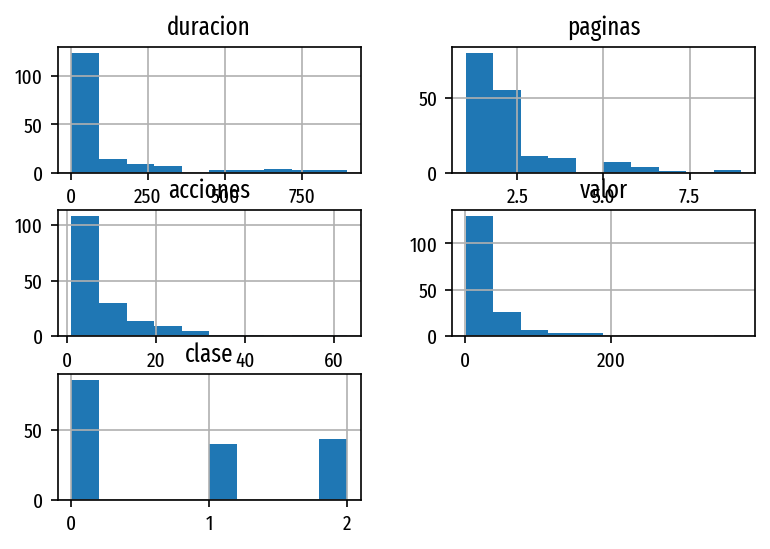

In [143]:
hist = data_web.hist(bins=10)

## Pairplot 

Pairplot para ver relaciones

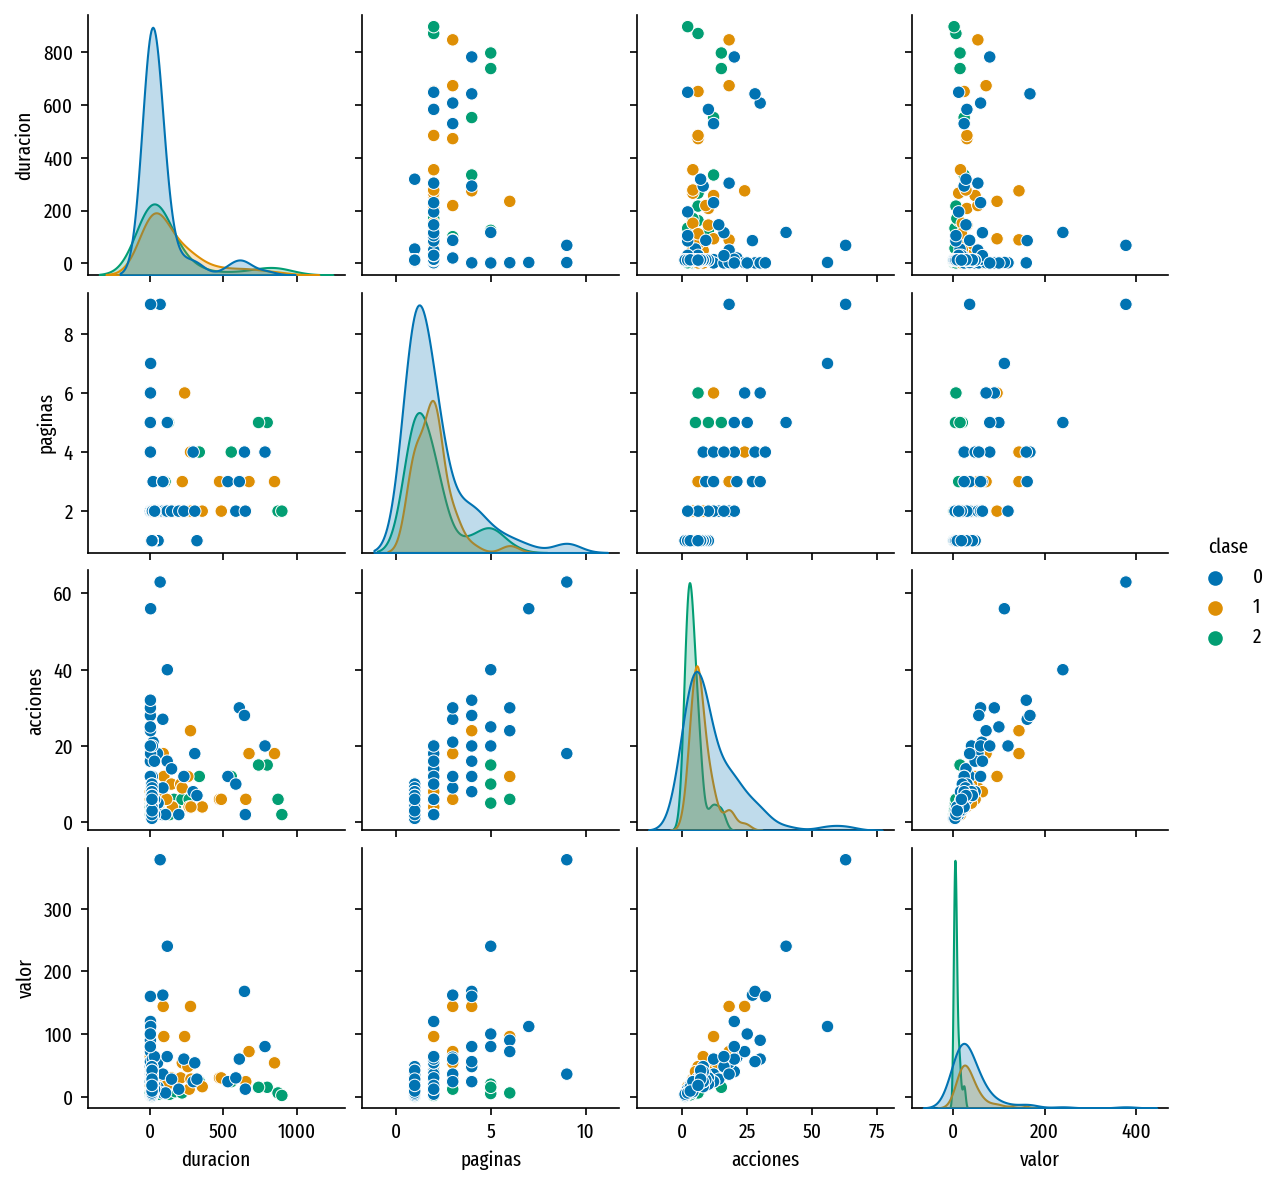

In [144]:
sns.pairplot(data_web, hue="clase", height = 2, palette = 'colorblind')

## Heatmap para ver correlación

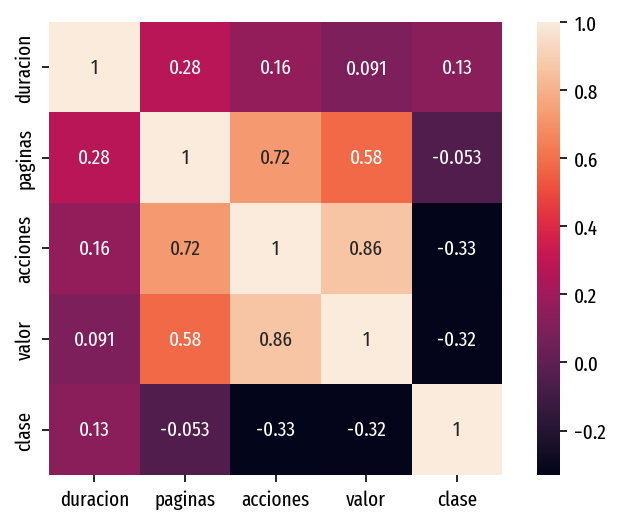

In [145]:
corr = data_web.corr()
sns.heatmap(corr, annot = True, square = True);

## Datos de entrenamiento y test

In [4]:
X=data_web[['duracion', 'paginas', 'acciones', 'valor']]  
y=data_web['clase']  

In [133]:
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                                                              random_state=2)  #stratify=y,
# Genero pesos
pesos = {
    0:0.5116279,
    1:0.2558135,
    2:0.23255813
}

## PCA

Entrenamiento modelo PCA con escalado de los datos

In [39]:
pca_pipe = make_pipeline(StandardScaler(), PCA(random_state=2)) # Estandar Scaler estandariza, PCA obtiene componentes
pca_pipe.fit(X_train)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

In [40]:
# Se combierte el array a dataframe para añadir nombres a los ejes.
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = data_web.drop('clase', axis=1).columns,
    index   = ['PC1', 'PC2','PC3', 'PC4']
)

,duracion,paginas,acciones,valor
PC1,0.180450,0.551160,0.594140,0.557367
PC2,0.956052,0.081963,-0.134319,-0.247395
PC3,-0.230872,0.782263,-0.125754,-0.564755
PC4,-0.009999,-0.278512,0.783033,-0.556048


## Análisis visual de los componentes

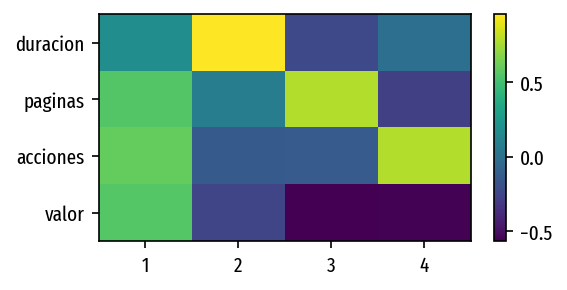

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 2))
componentes = modelo_pca.components_
plt.imshow(componentes.T, cmap='viridis', aspect='auto')
plt.yticks(range(len(X_train.columns)), X_train.columns)
plt.xticks(range(modelo_pca.n_components_), np.arange(modelo_pca.n_components_) + 1)
plt.grid(False)
plt.colorbar()

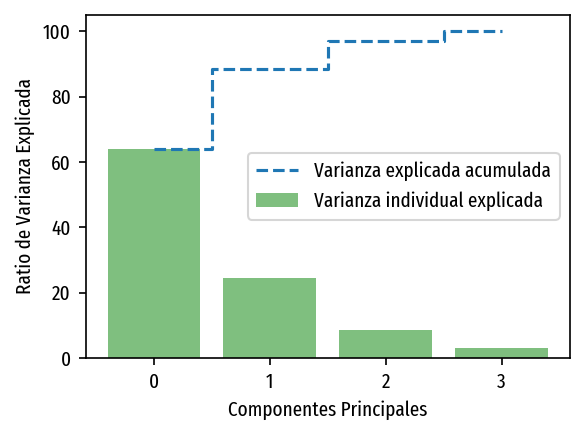

In [42]:
# A partir de los autovalores, calculamos la 
# varianza explicada (% representatividad)
var_exp = modelo_pca.explained_variance_ratio_ *100  # ratio de varianza explicada por 100 (para que quede en %)
cum_var_exp = np.cumsum(var_exp) # varianza acumulada por componente 

n_components = len(modelo_pca.components_)
# Representamos en un diagrama de barras la varianza explicada por cada autovalor, y la acumulada
# with plt.style.context('seaborn-pastel'):
plt.figure(figsize=(4, 3))

plt.bar(range(n_components), var_exp, alpha=0.5, align='center',
        label='Varianza individual explicada', color='g')
plt.step(range(n_components), cum_var_exp, where='mid', linestyle='--', label='Varianza explicada acumulada')
plt.ylabel('Ratio de Varianza Explicada')
plt.xlabel('Componentes Principales')
plt.legend(loc='best')
plt.tight_layout()
## Pendiente -> anotar labels 

# Modelo 1 - Random Forest

In [77]:
# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
# N components = 4 por el análisis anterior
pca_pipe = make_pipeline(StandardScaler(), PCA(), RandomForestClassifier(random_state=2, class_weight=pesos) ) # Estandar Scaler estandariza, PCA obtiene componentes
pca_pipe.fit(X_train.values, y_train.values)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight={0: 0.5116279,
                                                      1: 0.2558135,
                                                      2: 0.23255813},
                                        random_state=2))])

In [78]:
predicciones = pca_pipe.predict(X = X_test.values)
print(metrics.classification_report(y_true = y_test,
y_pred = predicciones
))

              precision    recall  f1-score   support

           0       0.70      0.81      0.75        26
           1       0.75      0.50      0.60        12
           2       0.77      0.77      0.77        13

    accuracy                           0.73        51
   macro avg       0.74      0.69      0.71        51
weighted avg       0.73      0.73      0.72        51



In [79]:
pca_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'pca', 'randomforestclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclass

In [80]:
pca_pipe._final_estimator.feature_importances_

array([0.23256117, 0.23230754, 0.28587996, 0.24925133])

## Búsqueda de grilla - GridSearch

Generamos una búsqueda de grilla para optimizar los hiperparámetros

In [81]:
param_dict = {
            "pca__n_components" : [1,2,3,4],
            "randomforestclassifier__criterion": ['gini', 'entropy'],
            "randomforestclassifier__n_estimators":[100,150,200,500,1000],
            'randomforestclassifier__max_features':   [1,2,3,4]
              }

estimator = GridSearchCV(pca_pipe,
                         param_dict,
                         verbose=2,
                         scoring='f1_macro')

In [82]:
estimator.fit(X_train, y_train)
# Da un error cuando el numero de max features no coincide con el n de componentes. No afecta la estimación de los demás.

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV] END pca__n_components=1, randomforestclassifier__criterion=gini, randomforestclassifier__max_features=1, randomforestclassifier__n_estimators=100; total time=   0.1s
[CV] END pca__n_components=1, randomforestclassifier__criterion=gini, randomforestclassifier__max_features=1, randomforestclassifier__n_estimators=100; total time=   0.1s
[CV] END pca__n_components=1, randomforestclassifier__criterion=gini, randomforestclassifier__max_features=1, randomforestclassifier__n_estimators=100; total time=   0.1s
[CV] END pca__n_components=1, randomforestclassifier__criterion=gini, randomforestclassifier__max_features=1, randomforestclassifier__n_estimators=100; total time=   0.1s
[CV] END pca__n_components=1, randomforestclassifier__criterion=gini, randomforestclassifier__max_features=1, randomforestclassifier__n_estimators=100; total time=   0.1s
[CV] END pca__n_components=1, randomforestclassifier__criterion=gini, randomforest

/Users/fabianalexis/opt/anaconda3/envs/analisis-de-datos/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/fabianalexis/opt/anaconda3/envs/analisis-de-datos/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/fabianalexis/opt/anaconda3/envs/analisis-de-datos/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/fabianalexis/op

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight={0: 0.5116279,
                                                                             1: 0.2558135,
                                                                             2: 0.23255813},
                                                               random_state=2))]),
             param_grid={'pca__n_components': [1, 2, 3, 4],
                         'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_features': [1, 2, 3, 4],
                         'randomforestclassifier__n_estimators': [100, 150, 200,
                                                                  500, 1000]},

Selecciono modelo de la búsqueda de Grid 

In [83]:
modelo_final = estimator.best_estimator_
modelo_final

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight={0: 0.5116279,
                                                      1: 0.2558135,
                                                      2: 0.23255813},
                                        max_features=4, n_estimators=500,
                                        random_state=2))])

### Test del modelo

In [84]:
predicciones = modelo_final.predict(X = X_test)
print(
    metrics.classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)

              precision    recall  f1-score   support

           0       0.79      0.85      0.81        26
           1       0.67      0.50      0.57        12
           2       0.86      0.92      0.89        13

    accuracy                           0.78        51
   macro avg       0.77      0.76      0.76        51
weighted avg       0.78      0.78      0.78        51



El F1 macro del modelo es de 0.76

### Predict y export para Binnario

In [85]:
predicciones = modelo_final.predict(data_validation)
predicciones

array([2, 2, 2, 0, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1])

In [86]:
pd.DataFrame(predicciones).to_csv("output/rfc-2.csv", index = False, header=None)

# Modelo 2 - Gradient Boost

Grid de hiperparámetros evaluados, Búsqueda por grid search con validación cruzada

In [134]:
pca_pipe = make_pipeline(StandardScaler(), PCA(), GradientBoostingClassifier(random_state=2) ) # Estandar Scaler estandariza, PCA obtiene componentes
pca_pipe.fit(X_train.values, y_train.values)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=2))])

Genero estimador en vaze al pipeline

In [135]:
estimador =  pca_pipe

### Búsqueda de grilla

In [136]:
param_grid = {'pca__n_components': [2,3,4],
                'gradientboostingclassifier__n_estimators'  : [50, 100, 500],
              'gradientboostingclassifier__max_features'  : ['auto', 'sqrt', 'log2'],
              'gradientboostingclassifier__max_depth'     : [None, 3, 4,5],
              'gradientboostingclassifier__subsample'     : [0.5, 0.8,1],
              'gradientboostingclassifier__learning_rate' : [0.001, 0.01, 0.1],
             'gradientboostingclassifier__min_samples_leaf': [20,30,50]
             }
# ==============================================================================
grid = GridSearchCV(
        estimator  = estimador,
        param_grid = param_grid,
        scoring    = 'f1_macro',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=2), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=3, random_state=2),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=2))]),
             n_jobs=7,
             param_grid={'gradientboostingclassifier__learning_rate': [0.001,
                                                                       0.01,
                                                                       0.1],
                         'gradientboostingclassifier__max_depth': [None, 3, 4,
                                                                   5],
                         'gradientboostingclassifier__max_features': ['auto',
                                                                      'sqrt',
                                                                      'log2'],

### Resultados

In [137]:
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t|scor)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,mean_score_time,std_score_time,param_gradientboostingclassifier__learning_rate,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__max_features,param_gradientboostingclassifier__min_samples_leaf,param_gradientboostingclassifier__n_estimators,param_gradientboostingclassifier__subsample,param_pca__n_components,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2537,0.003032,0.001633,0.1,4,sqrt,20,500,1,4,0.658784,0.57619,0.707757,0.647577,0.054293,1,0.975581,0.955977,0.987541,0.973033,0.013011
2051,0.004425,0.001828,0.1,None,sqrt,20,500,1,4,0.658784,0.57619,0.707757,0.647577,0.054293,1,0.975581,0.955977,0.987541,0.973033,0.013011
2780,0.002851,0.000685,0.1,5,sqrt,20,500,1,4,0.658784,0.57619,0.707757,0.647577,0.054293,1,0.975581,0.955977,0.987541,0.973033,0.013011
2294,0.002415,0.000694,0.1,3,sqrt,20,500,1,4,0.658784,0.57619,0.707757,0.647577,0.054293,1,0.975581,0.955977,0.987541,0.973033,0.013011


Mejores hiperparámetros por validación cruzada

In [142]:
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

{'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': None, 'gradientboostingclassifier__max_features': 'sqrt', 'gradientboostingclassifier__min_samples_leaf': 20, 'gradientboostingclassifier__n_estimators': 500, 'gradientboostingclassifier__subsample': 1, 'pca__n_components': 4} : 0.6475773020840659 f1_macro


### Predict con datos de prueba

In [139]:
predicciones = grid.best_estimator_.predict(X = X_test)
print(metrics.classification_report(y_true = y_test,
y_pred = predicciones
))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79        25
           1       0.64      0.82      0.72        11
           2       0.86      0.80      0.83        15

    accuracy                           0.78        51
   macro avg       0.78      0.79      0.78        51
weighted avg       0.80      0.78      0.79        51



el F1-Score macro del modelo es de 0.78

### Predict y export para Binnario

In [140]:
predicciones = grid.best_estimator_.predict(data_validation)
predicciones

array([2, 2, 2, 0, 1, 0, 0, 1, 1, 2, 1, 0, 1, 1])

In [141]:
pd.DataFrame(predicciones).to_csv("output/gradient-boost-2.csv", index = False, header=None)

# Modelo 3 - Gradient Boosting con oversampling

In [148]:
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                                                              random_state=2) 

In [161]:
oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

<AxesSubplot:>

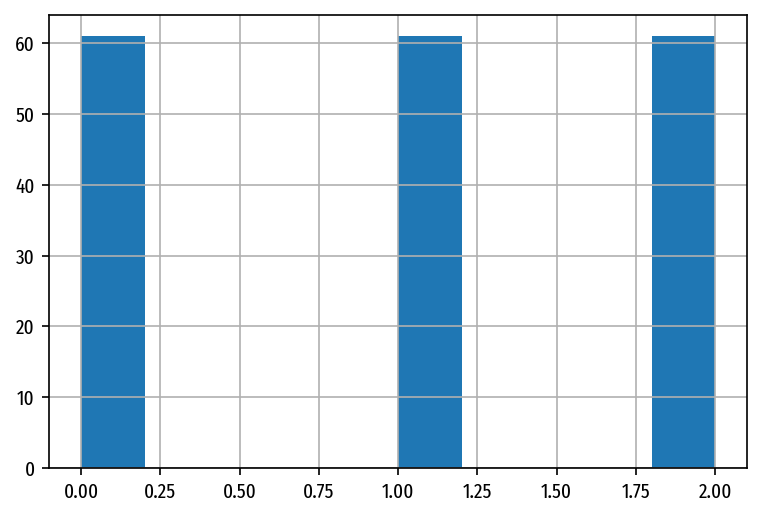

In [162]:
y_train_over.hist()

Modelo

In [163]:
pca_pipe = make_pipeline(StandardScaler(), PCA(), GradientBoostingClassifier(random_state=2) ) # Estandar Scaler estandariza, PCA obtiene componentes
pca_pipe.fit(X_train_over.values, y_train_over.values)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=2))])

Estimador GB con OverSample

In [164]:
estimador_os =  pca_pipe

Grid Search

In [166]:
param_grid = {'pca__n_components': [2,3,4],
                'gradientboostingclassifier__n_estimators'  : [50, 100, 500],
              'gradientboostingclassifier__max_features'  : ['auto', 'sqrt', 'log2'],
              'gradientboostingclassifier__max_depth'     : [None, 3, 4,5],
              'gradientboostingclassifier__subsample'     : [0.5, 0.8,1],
              'gradientboostingclassifier__learning_rate' : [0.001, 0.01, 0.1],
             'gradientboostingclassifier__min_samples_leaf': [20,30,50]
             }
# ==============================================================================
grid = GridSearchCV(
        estimator  = estimador_os,
        param_grid = param_grid,
        scoring    = 'f1_macro',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=2), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_over, y = y_train_over)

GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=3, random_state=2),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=2))]),
             n_jobs=7,
             param_grid={'gradientboostingclassifier__learning_rate': [0.001,
                                                                       0.01,
                                                                       0.1],
                         'gradientboostingclassifier__max_depth': [None, 3, 4,
                                                                   5],
                         'gradientboostingclassifier__max_features': ['auto',
                                                                      'sqrt',
                                                                      'log2'],

Resultados

In [167]:
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t|scor)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,mean_score_time,std_score_time,param_gradientboostingclassifier__learning_rate,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__max_features,param_gradientboostingclassifier__min_samples_leaf,param_gradientboostingclassifier__n_estimators,param_gradientboostingclassifier__subsample,param_pca__n_components,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2861,0.002807,0.000257,0.1,5,log2,20,500,1,4,0.724933,0.662637,0.775794,0.721121,0.046275,1,0.975519,0.991655,0.974836,0.98067,0.007773
2132,0.003259,0.000741,0.1,None,log2,20,500,1,4,0.724933,0.662637,0.775794,0.721121,0.046275,1,0.975519,0.991655,0.974836,0.98067,0.007773
2051,0.002778,0.000040,0.1,None,sqrt,20,500,1,4,0.724933,0.662637,0.775794,0.721121,0.046275,1,0.975519,0.991655,0.974836,0.98067,0.007773
2780,0.002726,0.000132,0.1,5,sqrt,20,500,1,4,0.724933,0.662637,0.775794,0.721121,0.046275,1,0.975519,0.991655,0.974836,0.98067,0.007773


Mejores hiperparámetros

In [168]:
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

{'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': None, 'gradientboostingclassifier__max_features': 'sqrt', 'gradientboostingclassifier__min_samples_leaf': 20, 'gradientboostingclassifier__n_estimators': 500, 'gradientboostingclassifier__subsample': 1, 'pca__n_components': 4} : 0.7211210292589355 f1_macro


Predict con los datos de prueba

In [169]:
predicciones = grid.best_estimator_.predict(X = X_test)
print(metrics.classification_report(y_true = y_test,
y_pred = predicciones
))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82        25
           1       0.64      0.82      0.72        11
           2       0.92      0.80      0.86        15

    accuracy                           0.80        51
   macro avg       0.80      0.81      0.80        51
weighted avg       0.82      0.80      0.81        51



El F1-Score del modelo es de 0.80 

### Export para Binnario

In [170]:
predicciones = grid.best_estimator_.predict(data_validation)
predicciones

array([2, 2, 2, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1])

In [171]:
pd.DataFrame(predicciones).to_csv("output/gradient-boost-over-3.csv", index = False, header=None)

# Conclusiones

El modelo con mejores resultados fue el Gradient Boosting utilizando Oversampling, en donde el f1 macro average fue de 0.8, mejorando la perfomance del modelo Random Forest (0.76) y el Gradient Boosting sin oversampling. (0.78)